<a href="https://colab.research.google.com/github/sayakpaul/Adventures-in-TensorFlow-Lite/blob/master/DeepLabV3/DeepLab_TFLite_COCO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Reference: https://colab.research.google.com/github/tensorflow/models/blob/master/research/deeplab/deeplab_demo.ipynb. Thanks to [Khanh](https://twitter.com/khanhlvg) for helping out with the issues. The models used here were trained on the COCO dataset. 

## Setup

In [1]:
%tensorflow_version 1.x
import tensorflow as tf
print(tf.__version__)

TensorFlow 1.x selected.
1.15.2


## Loading the model files

In [2]:
#@title Downloading and extracting the model checkpoints

MODEL_NAME = 'xception_coco_voctrainval'  # @param ['mobilenetv2_dm05_coco_voc_trainval', 'mobilenetv2_coco_voctrainval', 'xception_coco_voctrainval']

DOWNLOAD_URL_PREFIX = 'http://download.tensorflow.org/models/'
MODEL_URLS = {
    'mobilenetv2_dm05_coco_voc_trainval':
        'deeplabv3_mnv2_dm05_pascal_trainval_2018_10_01.tar.gz',
    'mobilenetv2_coco_voctrainval':
        'deeplabv3_mnv2_pascal_train_aug_2018_01_29.tar.gz',
    'xception_coco_voctrainval':
        'deeplabv3_pascal_trainval_2018_01_04.tar.gz',
}

import os
MODEL_URL = DOWNLOAD_URL_PREFIX + MODEL_URLS[MODEL_NAME]
MODEL_FILE = MODEL_URL.split('/')[4]

!wget {MODEL_URL}

import tarfile
FROZEN_GRAPH_NAME = 'frozen_inference_graph'
tar_file = tarfile.open(MODEL_FILE)
for tar_info in tar_file.getmembers():
    if FROZEN_GRAPH_NAME in os.path.basename(tar_info.name):
        print("Frozen graph found at: ",tar_info.name)
        file_handle = tar_file.extractfile(tar_info)

--2020-06-12 07:11:02--  http://download.tensorflow.org/models/deeplabv3_pascal_trainval_2018_01_04.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 74.125.195.128, 2607:f8b0:400e:c03::80
Connecting to download.tensorflow.org (download.tensorflow.org)|74.125.195.128|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 460669898 (439M) [application/x-tar]
Saving to: ‘deeplabv3_pascal_trainval_2018_01_04.tar.gz’

deeplabv3_pascal_tr 100%[===================>] 439.33M  50.6MB/s    in 9.3s    

2020-06-12 07:11:12 (47.1 MB/s) - ‘deeplabv3_pascal_trainval_2018_01_04.tar.gz’ saved [460669898/460669898]

Frozen graph found at:  deeplabv3_pascal_trainval/frozen_inference_graph.pb


## Creating SavedModel from of the frozen graph

In [3]:
# The preprocessing and the post-processing steps should not be included in the TF Lite model graph 
# because some operations (ArgMax) might not support the delegates. 
# Insepct the graph using Netron.
import tempfile

graph_def = tf.GraphDef()
graph_def.ParseFromString(file_handle.read())

with tf.Session(graph=tf.Graph()) as sess:
    tf.import_graph_def(graph_def, name="")
    
    g = tf.get_default_graph()

    # Need to remove the pre-processing and post-processing subgraph
    # https://github.com/tensorflow/models/blob/462459131a741f87c410b5fa51ec9df2c1b1c3ae/research/deeplab/export_model.py#L77
    input_tensor = g.get_tensor_by_name('sub_7:0')
    output_tensor = g.get_tensor_by_name('ResizeBilinear_2:0')

    saved_model_dir = tempfile.mkdtemp()

    tf.saved_model.simple_save(
        sess,
        saved_model_dir,
        inputs={input_tensor.name: input_tensor},
        outputs={output_tensor.name: output_tensor}
    )

Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.simple_save.
Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.utils.build_tensor_info or tf.compat.v1.saved_model.build_tensor_info.
INFO:tensorflow:Assets added to graph.
INFO:tensorflow:No assets to write.
INFO:tensorflow:SavedModel written to: /tmp/tmphsb15hcf/saved_model.pb


In [4]:
!ls -lh {saved_model_dir}

total 159M
-rw-r--r-- 1 root root 159M Jun 12 07:11 saved_model.pb
drwxr-xr-x 2 root root 4.0K Jun 12 07:11 variables


## Switch to TensorFlow 2

***Restart your runtime before executing the below code snippets.***

In [1]:
%tensorflow_version 2.x
import tensorflow as tf 
print(tf.__version__)

2.2.0


## Conversion to TF Lite

In [2]:
converter = tf.lite.TFLiteConverter.from_saved_model('/tmp/tmp3oxf607o/') # Change accordingly from the previous step
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [3]:
import tempfile

_, tflite_path = tempfile.mkstemp('.tflite')

with open(tflite_path, 'wb') as f:
    f.write(tflite_model)

!ls -lh {tflite_path}

-rw------- 1 root root 2.2M Jun 12 07:11 /tmp/tmpss3_mzp0.tflite


## Inference

In [4]:
# Load the model.
interpreter = tf.lite.Interpreter(model_path=tflite_path)

# Set model input.
input_details = interpreter.get_input_details()
interpreter.allocate_tensors()

# get image size - converting from BHWC to WH
input_size = input_details[0]['shape'][2], input_details[0]['shape'][1]
print(input_size)

(513, 513)


In [5]:
#@title Provide a URL to your image to download
IMAGE_URL = 'https://github.com/tensorflow/models/raw/master/research/deeplab/g3doc/img/image3.jpg' #@param {type:"string"}
!wget {IMAGE_URL}

--2020-06-12 07:12:02--  https://github.com/tensorflow/models/raw/master/research/deeplab/g3doc/img/image3.jpg
Resolving github.com (github.com)... 192.30.255.112
Connecting to github.com (github.com)|192.30.255.112|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/tensorflow/models/master/research/deeplab/g3doc/img/image3.jpg [following]
--2020-06-12 07:12:02--  https://raw.githubusercontent.com/tensorflow/models/master/research/deeplab/g3doc/img/image3.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 108846 (106K) [image/jpeg]
Saving to: ‘image3.jpg’

image3.jpg          100%[===================>] 106.29K  --.-KB/s    in 0.02s   

2020-06-12 07:12:02 (4.40 MB/s) - ‘image3.jpg’ saved [108846/10884

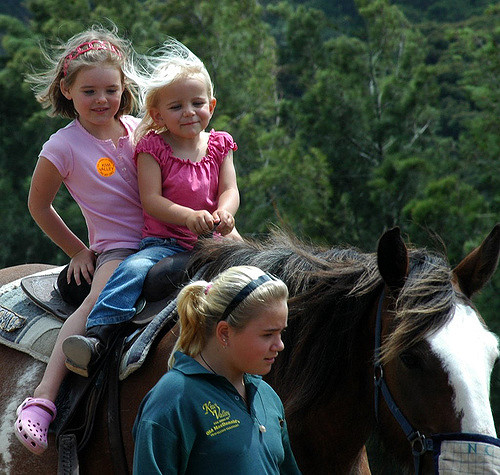

In [6]:
from PIL import Image

image = Image.open('image3.jpg') # Change this filename accordingly
image

In [0]:
# Preprocessing: convert the input image to the size required by the model
# Courtesy: Khanh
import numpy as np 

resized_image = image.convert('RGB').resize(input_size, Image.BILINEAR)

# Convert to a NumPy array, add a batch dimension, and normalize the image.
image_for_prediction = np.asarray(resized_image).astype(np.float32)
image_for_prediction = np.expand_dims(image_for_prediction, 0)
image_for_prediction = image_for_prediction / 127.5 - 1

# Load the model.
interpreter = tf.lite.Interpreter(model_path=tflite_path)

# Invoke the interpreter to run inference.
interpreter.allocate_tensors()
interpreter.set_tensor(input_details[0]['index'], image_for_prediction)
interpreter.invoke()

# Retrieve the raw output map.
raw_prediction = interpreter.tensor(
    interpreter.get_output_details()[0]['index'])()

# Post-processing: convert raw output to segmentation output
## Method 1: argmax before resize - this is used in some frozen graph
# seg_map = np.squeeze(np.argmax(raw_prediction, axis=3)).astype(np.int8)
# seg_map = np.asarray(Image.fromarray(seg_map).resize(image.size, resample=Image.NEAREST))
## Method 2: resize then argmax - this is used in some other frozen graph and produce smoother output
width, height = image.size
seg_map = tf.argmax(tf.image.resize(raw_prediction, (height, width)), axis=3)
seg_map = tf.squeeze(seg_map).numpy().astype(np.int8)

The following code comes from https://colab.research.google.com/github/tensorflow/models/blob/master/research/deeplab/deeplab_demo.ipynb. 

In [0]:
#@title
from matplotlib import gridspec
from matplotlib import pyplot as plt

def create_pascal_label_colormap():
  """Creates a label colormap used in PASCAL VOC segmentation benchmark.

  Returns:
    A Colormap for visualizing segmentation results.
  """
  colormap = np.zeros((256, 3), dtype=int)
  ind = np.arange(256, dtype=int)

  for shift in reversed(range(8)):
    for channel in range(3):
      colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

  return colormap


def label_to_color_image(label):
  """Adds color defined by the dataset colormap to the label.

  Args:
    label: A 2D array with integer type, storing the segmentation label.

  Returns:
    result: A 2D array with floating type. The element of the array
      is the color indexed by the corresponding element in the input label
      to the PASCAL color map.

  Raises:
    ValueError: If label is not of rank 2 or its value is larger than color
      map maximum entry.
  """
  if label.ndim != 2:
    raise ValueError('Expect 2-D input label')

  colormap = create_pascal_label_colormap()

  if np.max(label) >= len(colormap):
    raise ValueError('label value too large.')

  return colormap[label]


def vis_segmentation(image, seg_map):
  """Visualizes input image, segmentation map and overlay view."""
  plt.figure(figsize=(15, 5))
  grid_spec = gridspec.GridSpec(1, 4, width_ratios=[6, 6, 6, 1])

  plt.subplot(grid_spec[0])
  plt.imshow(image)
  plt.axis('off')
  plt.title('input image')

  plt.subplot(grid_spec[1])
  seg_image = label_to_color_image(seg_map).astype(np.uint8)
  plt.imshow(seg_image)
  plt.axis('off')
  plt.title('segmentation map')

  plt.subplot(grid_spec[2])
  plt.imshow(image)
  plt.imshow(seg_image, alpha=0.7)
  plt.axis('off')
  plt.title('segmentation overlay')

  unique_labels = np.unique(seg_map)
  ax = plt.subplot(grid_spec[3])
  plt.imshow(
      FULL_COLOR_MAP[unique_labels].astype(np.uint8), interpolation='nearest')
  ax.yaxis.tick_right()
  plt.yticks(range(len(unique_labels)), LABEL_NAMES[unique_labels])
  plt.xticks([], [])
  ax.tick_params(width=0.0)
  plt.grid('off')
  plt.show()


LABEL_NAMES = np.asarray([
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
])

FULL_LABEL_MAP = np.arange(len(LABEL_NAMES)).reshape(len(LABEL_NAMES), 1)
FULL_COLOR_MAP = label_to_color_image(FULL_LABEL_MAP)

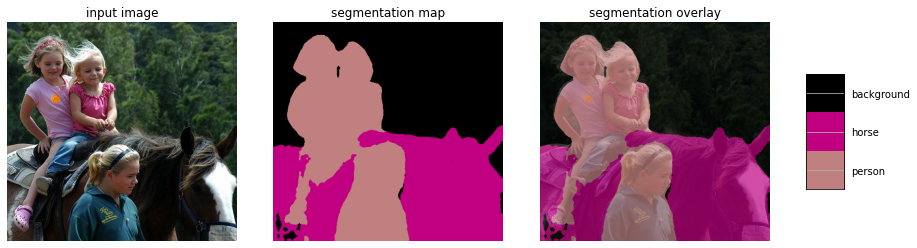

In [9]:
vis_segmentation(image, seg_map)


To try out a new model it's advisable to Factory Reset the runtime and then trying it.